### Preliminary Actions: Read the data set from csv file. Create dummy variables for the nine levels of rural_urbal_continuum_codes (RUCC) and the four geographical regions. Create the predictors data frame and the target variable series.

In [29]:
# Set the backend of matplotlib to inline
%matplotlib inline

# Improt necessary libraries
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns

# Set style and context
sns.set_style('whitegrid')
sns.set_context('talk')

# Load the data set
df = pd.read_csv('wrangled_data.csv')
# Remove the .0 after RUCC numbers and transform it to string
df.RUCC=df.RUCC.astype('int').astype('str')

# define the predictors dataframe and the target variable series
X = df.drop(['state','county','poverty'],axis=1)
#X = df.loc[:,['unemployment','RUCC','region']]
y = df['poverty']

# Create dummy variables for region and RUCC
X=pd.get_dummies(X)

# drop one column of dummy variable from each categorical variable to avoid collinearity
# The correlations between poverty and majority of rural urban continuum codes i.e. all except RUCC 1 and 6, 
# are close to each other . Therefore, any of these seven RUCC could be picked as the base to simplify the interpretation. 
# I pick RUCC 9 and remove it
# The correlations between poverty and the four geographical regions are different from each other. Therefore, any of them 
# could be picked as the base. I pick Midwest and remove it
# Also, the sum of the four education levels is 100 and one of them must be removed to avoid collinearity. 
# Since poverty is positively correlated with lower education (this was shown in Story Telling), I removed the highest education
# level which is bachelors/higher

X.drop(['region_Midwest','RUCC_9','bachelors/higher','unemployment'],axis=1,inplace=True)
#X.drop(['region_Midwest','RUCC_9'],axis=1,inplace=True)
#Print the first five rows of X
X.head()

,unemployment,RUCC_1,RUCC_2,RUCC_3,RUCC_4,RUCC_5,RUCC_6,RUCC_7,RUCC_8,region_Northeast,region_South,region_West
0,5.3,0,1,0,0,0,0,0,0,0,1,0
1,5.4,0,0,1,0,0,0,0,0,0,1,0
2,8.6,0,0,0,0,0,1,0,0,0,1,0
3,6.6,1,0,0,0,0,0,0,0,0,1,0
4,5.5,1,0,0,0,0,0,0,0,0,1,0


### Step 1: Build a linear model: there are 15 predictors and more than 3000 samples. Therefore, I will build a model based on all predictors, run a cross-validation, and average them to find an estimate for the test set score. At the end, fit the linear model to the entire dataset.

In [30]:
# Build the linear classifier and calculate the average score
clf = LinearRegression()
scores = cross_val_score(clf,X,y,cv=5)
print('The average of 5-fold cross-validation for the linear model fitted to the entire dataset is %.3f'%np.mean(scores))

# Fit the linear model on the entire dataset
model = sm.OLS(y,X).fit()

The average of 5-fold cross-validation for the linear model fitted to the entire dataset is 0.433


### Step 2: Simplify the linear model: remove the predictors with p-values lower than 0.01, refit the model to the new dataset, find an estimate for the test set score, and compare it to the test score of the model fitted to the entire dataset in step 1. At the end, fit the linear model to the dataset with reduced number of predictors

In [31]:
# Remove predcitors with p-value less than 0.01
X = X.loc[:,model.pvalues[model.pvalues <0.01].index]

# Print the set of reduced predictors
print ('The reduced set of predictors is: ',X.columns.tolist())

#Build the linear classifier and calculate the average score
clf = LinearRegression()
scores = cross_val_score(clf,X,y,cv=5)
print('\nThe average of 5-fold cross-validation for the linear model fitted to reduced number of predictors is %.3f'%np.mean(scores))

# fit the model on the dataset fitted on the reduced number of targets
model = sm.OLS(y,X).fit()


The reduced set of predictors is:  ['unemployment', 'RUCC_1', 'RUCC_3', 'RUCC_4', 'RUCC_5', 'RUCC_6', 'RUCC_7', 'RUCC_8', 'region_South']

The average of 5-fold cross-validation for the linear model fitted to reduced number of predictors is 0.429


### Observation
#### As it was expected, the estimate of the test set score did not significantly changed after removing the predictors with high p-values. As a result, the simplified model with only 7 predictors have the same accuracy as the model with 15 predictors

### Step 3: Find and investigate the outliers and exmaine how removing them will impact the R-sqaure. I consider a data point an outlier if the the absolute value of the external studentized residual corresponding to that point is more than 3. I pick 3 because more than 99% of the observations for a normal distribution fall within 3 standard deviation of the mean

#### Step 3-1: Find the outliers and analyze them

In [32]:
# Define the influence array and create a panda Series with the external studentized residuals
infl = model.get_influence()
p = pd.Series(infl.resid_studentized_external)

# Extract the indices of the series for which the absolute value of external studentized residual is more than 3
indices = p[np.abs(p)>3].index
df_outliers = df.iloc[indices]

print('Total number of outliers is ',len(indices), ' which is ',np.round(100*len(indices)/len(df),2), \
      ' percent of the total number of counties\n')

# Print the top 5 states with outlier counties, number of those counties,
#and the print this number as the percentage of total num ber of counties in that state
for state,value in df_outliers.state.value_counts().head().iteritems():
    a=(df['state'] == state).sum ()
    print('State ',state,' shows up ',value,' times in outliers. This number is ',np.round(value/a*100,2),\
        ' percent of the total number of counties in ', state)

Total number of outliers is  32  which is  1.02  percent of the total number of counties

State  SD  shows up  9  times in outliers. This number is  13.64  percent of the total number of counties in  SD
State  CO  shows up  5  times in outliers. This number is  7.81  percent of the total number of counties in  CO
State  AK  shows up  3  times in outliers. This number is  10.34  percent of the total number of counties in  AK
State  KY  shows up  3  times in outliers. This number is  2.5  percent of the total number of counties in  KY
State  TX  shows up  2  times in outliers. This number is  0.79  percent of the total number of counties in  TX


#### Step 3-2: Compute the R-square after removing the outliers

In [33]:
# Build the predictors dataframe and target variable panda series
X_reduced=X.iloc[p[np.abs(p)<=3].index]
y_reduced=y.iloc[p[np.abs(p)<=3].index]

# Build the classifier and calculate the average score
clf = LinearRegression()
scores = cross_val_score(clf,X_reduced,y_reduced,cv=5)
print('The average of 5-fold cross-validation for the linear model after removing the outliers is %.3f'%np.mean(scores))

The average of 5-fold cross-validation for the linear model after removing the outliers is 0.501


### Conclusion
#### By removing the outliers (observations with the absolute value of the external studentized residual more than 3), R-sqaured jumped from 0.52 to 0.60. The outliers formed less than 1.5% of the entire dataset, and there was only one state for which more than 10% of the data was removed. Therefore, removing the outliers did not result in loosing significant amount of data

### Step 3: Examine residual vs fitted value plot, quantile plot, and influence plot before and after removing the outliers

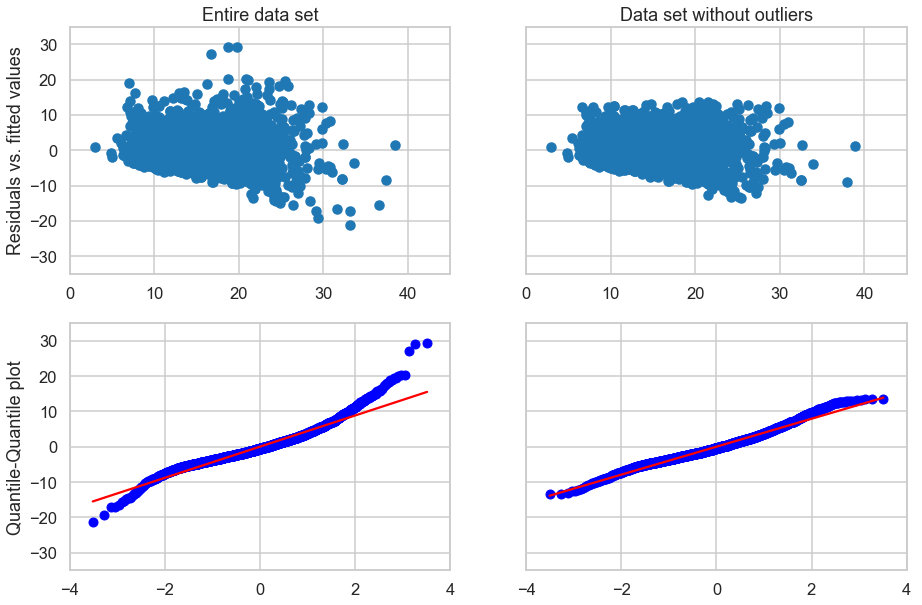

In [17]:
# fit the model on the entire data
model = sm.OLS(y,X).fit()

# fit the model on the data without outliers (reduced data)
model_reduced = sm.OLS(y_reduced,X_reduced).fit()

# Create subplots
figure,ax = plt.subplots(2,2,figsize=(15,10),sharex='row',sharey='row')

# Plot residuals vs. fitted values
ax[0,0].scatter(model.fittedvalues,model.resid)
ax[0,0].set_ylabel('Residuals vs. fitted values');
ax[0,0].set_title('Entire data set')
ax[0,0].axis([0,45,-35,35])
ax[0,1].scatter(model_reduced.fittedvalues,model_reduced.resid)
ax[0,1].set_title('Data set without outliers')

# Plot quantile plot
stats.probplot(model.resid,plot=ax[1,0])

ax[1,0].set_ylabel('Quantile-Quantile plot')
ax[1,0].set_xlabel('')
ax[1,0].set_title('')
ax[1,0].axis([-4,4,-35,35])
stats.probplot(model_reduced.resid,plot=ax[1,1])
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel('')
ax[1,1].set_title('')

plt.show()

In [9]:
X.head()

,less_than_high_school,high_school_diploma,college/associate_degree,region_South,region_West,RUCC_1
0,12.417,34.331,28.660,1,0,0
1,9.972,28.692,31.788,1,0,0
2,26.236,34.927,25.969,1,0,0
3,19.302,41.816,26.883,1,0,1
4,19.969,32.942,34.039,1,0,1


#### Influence plots are examined separately since they need more space

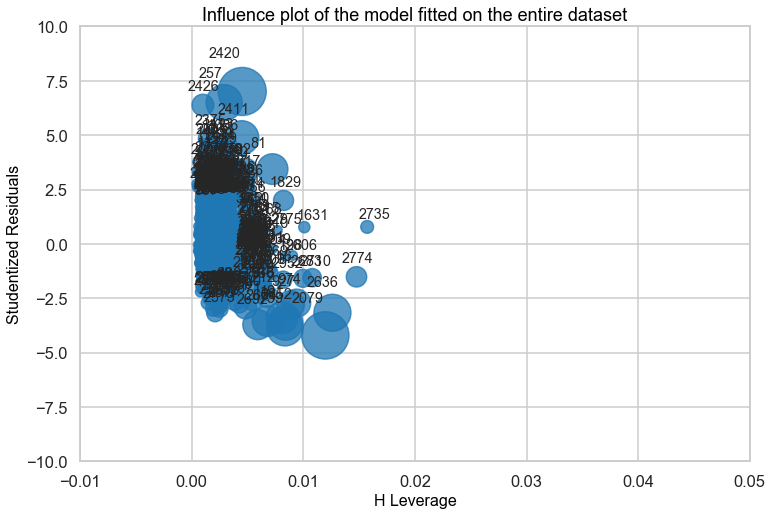

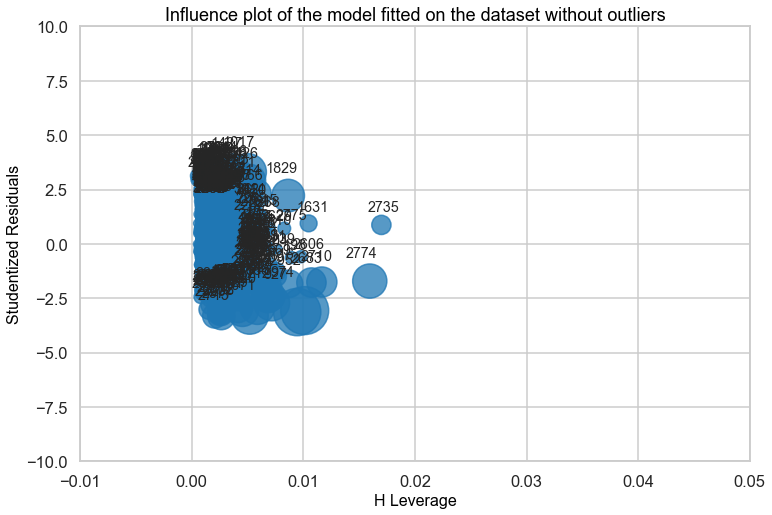

In [10]:
# Plot influence plot
fig, ax = plt.subplots(figsize=(12,8))
sm.graphics.influence_plot(model,criterion='cooks',ax=ax)
plt.title('Influence plot of the model fitted on the entire dataset')
plt.axis([-0.01,0.05,-10,10])

fig, ax = plt.subplots(figsize=(12,8))
sm.graphics.influence_plot(model_reduced,criterion='cooks',ax=ax)
plt.title('Influence plot of the model fitted on the dataset without outliers')
plt.axis([-0.01,0.05,-10,10])

plt.show()

### Observation

#### 1) residual vs. fitted values
#### 1.a) Linearity: In both plots (before and after removing the outliers) the residuals bounce randomly around the 0 line. This suggests that the assumption that the relationship is linear is reasonable in both models (model fit on the entire dataset and model fit on the dataset without outliers). 
#### 1.b) Independent errors: In both plots, the residuals roughly form a horizontal band around the 0 line. This suggests in each model, the variances of the error terms are quite equal and the assumption that the errors are independent is reasonable for both models.
#### 1.c) The main difference between the two plots is no one residual stands out from the basic random pattern of residuals in the dataset without outliers. In other words, the two mentioned assumptions in 1.a and 1.b (linearity and independent errors) are stronger in the model fitted on the dataset without outliers

#### 2) Quantile-Quantile plot: The plot for the entire dataset shows the distribution of the residuals is heavy tailed. Removing the outliers and refitting the model make the distribution of the residuals quite close to the normal distribution.

#### 3) Influence plot: The influence plot of the model fitted on the entire dataset include some data points with studentized residual of 7.5. After removing the outliers and refitting the model, there is no data point with the absolute value of studentized residual more than 5. 

#### Therefore, removing the outliers and refitting the model improves the assumptions on linearity, independent erros and normal distribution of errors. In addition, it eliminates the high studentized residuals.

### Step 4: Analyze the fitted linear model on the dataset without outliers

In [18]:
model_reduced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                poverty   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                 1.711e+04
Date:                Tue, 18 Dec 2018   Prob (F-statistic):               0.00
Time:                        15:40:51   Log-Likelihood:                -8663.5
No. Observations:                3090   AIC:                         1.733e+04
Df Residuals:                    3087   BIC:                         1.735e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
less_than_high_school        0.6838      0.011     60.460      0.000       0.662       0.706
high_school_diploma          0.1052      0.009     12.265      0.000       0.088       0.122
college/associate_degree     0.0794      0.008      9.912      0.000       0.064       0.095
==============================================================================
Omnibus:                      151.646   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.287
Skew:                           0.492   Prob(JB):                     1.07e-42
Kurtosis:                       3.729   Cond. No.                         8.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Step 4: Try other techniques and examine if the R-square improves. 

#### Step 4-1: The first technique I will work on is to add both nonlinearity and interaction between predictors to the model.

In [18]:
# Import necessary libraries
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Create linear regression classifier and polynomial features, and use pipeline
linear = LinearRegression()
poly = PolynomialFeatures(degree = 2, interaction_only = False)
pipeline = make_pipeline(poly, linear)

# Run cross-validation and print the results
scores = cross_val_score(pipeline,X,y,cv=5)
print('The average of 5-fold cross-validation of the new model is %.3f'%np.mean(scores))

The average of 5-fold cross-validation of the new model is 0.564


### Conclusion
#### The R-square of the test set for the model with second degree interactions and nonlinearity has not improved significantly compare to the linear model fitted on the entire dataset, and it is even lower the linear model fitted on the dataset without outliers

#### Step 4-2: The second technique I will work on is the random forest

In [48]:
#Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Build the classifier without parameter tuning, run cross-validation, and average the scores
forest = RandomForestRegressor(random_state=21)
scores = cross_val_score(forest,X,y,cv=5)
print('The average of 5-fold cross-validation for the random forest without parameter tuning is %.3f'%np.mean(scores))

The average of 5-fold cross-validation for the random forest without parameter tuning is 0.512


In [49]:
parameters = {'n_estimators':[10,50,100],\
              'criterion': ['mse','mae'],\
             'min_samples_leaf':[5,7,10],\
             'max_features':['auto','sqrt','log2']}
forest = RandomForestRegressor(random_state=21)
clf = GridSearchCV(forest,param_grid=parameters,cv=5)
clf.fit(X_train,y_train)
print('The test set score after tuning parameters is ',np.round(clf.score(X_test,y_test),3))
print('The best parameters are: ',clf.best_params_)

The test set score after tuning parameters is  0.627
The best parameters are:  {'criterion': 'mse', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}


#### Since the best values of n_estimators and min_samples_leaf are on one end of the tested values, I try some other values for them

In [50]:
parameters = {'n_estimators':[100, 200, 300],\
             'min_samples_leaf':[2, 3, 5]}
forest = RandomForestRegressor(criterion = 'mse', max_features = 'sqrt', random_state=21)
clf = GridSearchCV(forest,param_grid=parameters,cv=5)
clf.fit(X_train,y_train)
print('The test set score after tuning parameters is ',np.round(clf.score(X_test,y_test),3))
print('The best parameters are: ',clf.best_params_)

The test set score after tuning parameters is  0.633
The best parameters are:  {'min_samples_leaf': 2, 'n_estimators': 300}


#### The test score has slightly improved. Again, Since the best values of both parameters are on one end of the tested values, I try some other values for them

In [51]:
parameters = {'n_estimators':[300, 500, 1000],\
             'min_samples_leaf':[1,2]}
forest = RandomForestRegressor(criterion = 'mse', max_features = 'sqrt', random_state=21)
clf = GridSearchCV(forest,param_grid=parameters,cv=5)
clf.fit(X_train,y_train)
print('The test set score after tuning parameters is ',np.round(clf.score(X_test,y_test),3))
print('The best parameters are: ',clf.best_params_)

The test set score after tuning parameters is  0.627
The best parameters are:  {'min_samples_leaf': 1, 'n_estimators': 300}


#### The best value of n_estimators remains 300 as before but the best value of min_samples_leaf has changed. Since the test set score has not improved I stick to min_samples_leaf = 2. Now, I develop the model on the entire dataset and compute the score

In [52]:
clf = RandomForestRegressor(n_estimators = 300, min_samples_leaf = 2,criterion = 'mse', max_features = 'sqrt', random_state=21)
clf.fit(X,y)
print('The R-square of the random forest model fitted on the entire dataset is ',np.round(clf.score(X,y),3))

The R-square of the random forest model fitted on the entire dataset is  0.856
